In [87]:

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize
# from simpeg import dask
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation, MetaSimulation


Solver = get_default_solver()


In [88]:

# rx_locs = np.loadtxt(f"{directory}/rx_locs.txt")
# rx_locs[:, 1] =
tx_height = 30 

rx_x = (np.linspace(-300, 300, 61))
# rx_y = (np.linspace(-100, 100, 11))[::2]
rx_y = np.r_[0]
# rx_y = np.r_[0]
# rx_y = np.r_[-80, -40, 0, 40, 80]

rx_z = tx_height

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])
rx_x

# rx_times = np.loadtxt(f"{directory}/rx_times.txt")
rx_times = np.logspace(np.log10(2e-5), np.log10(2e-3), 20)
np.save("rx_times.npy", rx_times)

In [89]:
len(rx_locs[:, 0])

61

In [90]:
len(rx_x)

61

In [91]:
len(rx_locs[:, 0])

61

In [92]:
rx_times

array([2.00000000e-05, 2.54854997e-05, 3.24755348e-05, 4.13827616e-05,
       5.27330180e-05, 6.71963657e-05, 8.56266480e-05, 1.09111896e-04,
       1.39038559e-04, 1.77173358e-04, 2.25767578e-04, 2.87689978e-04,
       3.66596142e-04, 4.67144294e-04, 5.95270288e-04, 7.58538038e-04,
       9.66586048e-04, 1.23169642e-03, 1.56951994e-03, 2.00000000e-03])

In [93]:
# dobs_dict = {}

# for f in files:
#     key = f.split(".")[0]
#     dobs_dict[key] = np.loadtxt(f"{directory}/{f}")
    
# data_dict = {}
n_times_invert = 20
# for key, value in dobs_dict.items():
source_list = []
for i in range(rx_locs.shape[0]):
    rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times[:n_times_invert], orientation="z")
    src = tdem.sources.CircularLoop(
        receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
        waveform=tdem.sources.StepOffWaveform()
    )
    source_list.append(src)

full_survey = tdem.Survey(source_list)

    # data_dict[key] = Data(survey=full_survey, dobs=value)



In [94]:
# n_times_invert = 20
# data_dict_invert = {}
    
# for key, value in dobs_dict.items():

#     source_list = []

#     for i in range(rx_locs.shape[0]):
#         rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times[:n_times_invert], orientation="z")
#         src = tdem.sources.CircularLoop(
#             receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
#             waveform=tdem.sources.StepOffWaveform()
#         )
#         source_list.append(src)

#     survey = tdem.Survey(source_list)

#     data_dict_invert[key] = Data(
#         survey=survey,
#         dobs=(value.reshape(rx_locs.shape[0], len(rx_times))[:, :n_times_invert]).flatten(),
#         relative_error=0.1,
#         noise_floor=1e-11
#     )

In [95]:
survey = full_survey

In [96]:
downsample = 1
source_list_downsampled = survey.source_list[::downsample]

with open("survey.txt", "w") as f:
    f.write(f"N_TRX {len(source_list_downsampled)}\n\n")

    for src in source_list_downsampled: 
        f.write(f"TRX_LOOP\n")
        f.write(f"{src.location[0]} {src.location[1]} {src.location[2]} {src.radius} 0 0\n\n")

        f.write(f"N_RECV 1\n")
        f.write(f"N_TIME {n_times_invert}\n")
        for t in rx_times[:n_times_invert]:
            rx = src.receiver_list[0]
            f.write(f"{rx.locations[0, 0]} {rx.locations[0, 1]} {rx.locations[0, 2]} {t}\n")
        f.write("\n")
            


        

In [97]:
len(source_list_downsampled)

61

In [98]:
src = survey.source_list[0]
rx = src.receiver_list[0]

In [99]:
ubc_mesh = discretize.TreeMesh.read_UBC("octree_mesh.txt")

In [100]:
ubc_mesh

OcTreeMesh,0.00% filled
Level,Number of cells
3,104
4,760
5,2992
6,5068
7,1156
8,1828
9,2528
10,5700
11,13696


In [124]:
rho_back = 500
sigma_back = 1./rho_back 

rho_target = 20
sigma_target = 1./rho_target

sigma_air = 1e-8

target_x = np.r_[-40, 40]
target_y = np.r_[-200, 200]
target_z = np.r_[-100, -40]

In [125]:
model = np.ones(ubc_mesh.n_cells)*sigma_air

model[ubc_mesh.cell_centers[:, 2] < 0] = sigma_back

inds_target = (
    (ubc_mesh.cell_centers[:, 0] > target_x.min()) &
    (ubc_mesh.cell_centers[:, 1] > target_y.min()) &
    (ubc_mesh.cell_centers[:, 2] > target_z.min()) &
    (ubc_mesh.cell_centers[:, 0] < target_x.max()) &
    (ubc_mesh.cell_centers[:, 1] < target_y.max()) &
    (ubc_mesh.cell_centers[:, 2] < target_z.max()) 
)
model[inds_target] = sigma_target

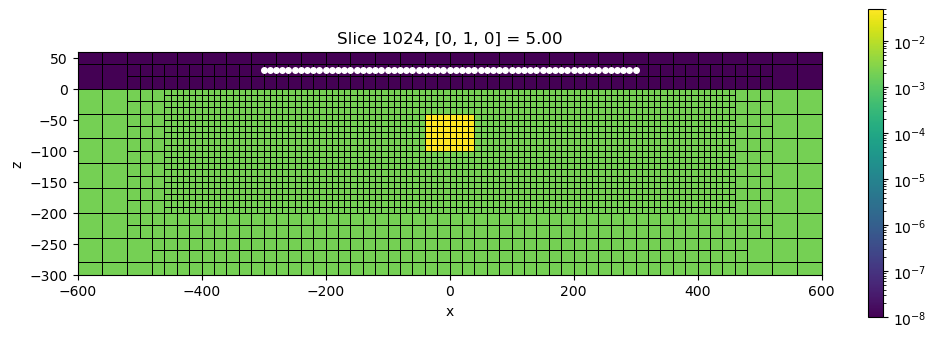

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax, pcolor_opts={"norm":LogNorm()}, 
        normal="Y",
        grid_opts={"color":"k","lw":0.5}
        # ind=1044
    )[0], ax=ax
)

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 60])
ax.plot(rx_locs[:, 0], rx_locs[:, 2], "wo", ms=4)
ax.set_aspect(1)

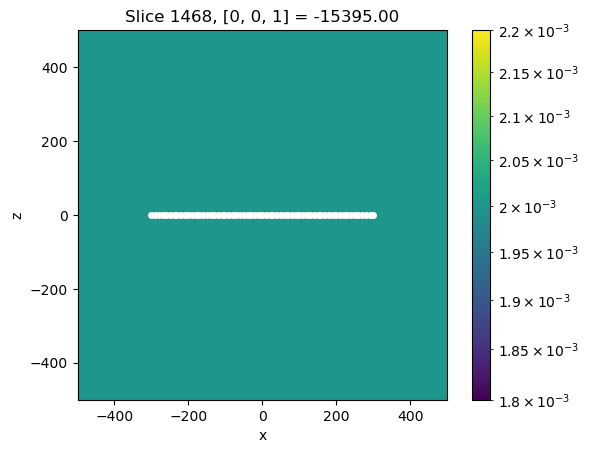

In [127]:
fig, ax = plt.subplots(1, 1)
plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax, pcolor_opts={"norm":LogNorm()}, 
        normal="Z", ind=1468
    )[0], 
    ax=ax
)

ax.set_xlim(500*np.r_[-1, 1])
ax.set_ylim(500*np.r_[-1, 1])

ax.plot(rx_locs[:, 0], rx_locs[:, 1], "wo", ms=4)
ax.set_aspect(1)

In [128]:
discretize.TreeMesh.write_model_UBC(ubc_mesh, "model.con", model)

In [129]:
np.save("rx_locs.npy", rx_locs)

In [130]:
relative_error = 0.05
noise_floor = 1e-13

In [131]:
time_steps = [
    (1e-6, 30),
    (3e-6, 30),
    (1e-5, 30), (3e-5, 20), (1e-4, 20), #(3e-4, 20)
]

In [132]:
full_time_mesh = np.cumsum(np.hstack([0, discretize.utils.unpack_widths(time_steps)]))
with open("waveform.txt", "w") as f:
    for i, t in enumerate(full_time_mesh): 
        if i == 0:
            f.write(f"{t} \t 1\n")
        else:
            f.write(f"{t} \t 0\n")

In [134]:
def load_pre_file(filepath):
    """
    Load a GIF-style .pre file (TDoctree format).

    Parameters
    ----------
    filepath : str
        Path to the .pre-style data file

    Returns
    -------
    dict
        {
            "ignore": float or None,
            "n_trx": int,
            "transmitters": list of {
                "location": list of float,
                "n_recv": int,
                "n_time": int,
                "receivers": list of {
                    "loc": (x, y, z),
                    "time": float,
                    "data": list of float
                }
            }
        }
    """
    with open(filepath, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    i = 0
    ignore_value = None
    transmitters = []

    # Parse IGNORE line if present
    if lines[i].startswith("IGNORE"):
        ignore_value = float(lines[i].split()[1])
        i += 1

    # Parse number of transmitters
    if lines[i].startswith("N_TRX"):
        n_trx = int(lines[i].split()[1])
        i += 1
    else:
        raise ValueError("Missing N_TRX line")

    while i < len(lines):
        if lines[i].startswith("TRX_LOOP"):
            i += 1
            location = list(map(float, lines[i].split()))
            i += 1
            if not lines[i].startswith("N_RECV"):
                raise ValueError("Expected N_RECV")
            n_recv = int(lines[i].split()[1])
            i += 1
            if not lines[i].startswith("N_TIME"):
                raise ValueError("Expected N_TIME")
            n_time = int(lines[i].split()[1])
            i += 1

            receivers = []
            for _ in range(n_recv * n_time):
                parts = lines[i].split()
                x, y, z = map(float, parts[0:3])
                time = float(parts[3])
                data = list(map(float, parts[4:]))
                receivers.append({
                    "loc": (x, y, z),
                    "time": time,
                    "data": data
                })
                i += 1

            transmitters.append({
                "location": location,
                "n_recv": n_recv,
                "n_time": n_time,
                "receivers": receivers
            })
        else:
            i += 1  # Skip unknown or empty lines

    return {
        "ignore": ignore_value,
        "n_trx": len(transmitters),
        "transmitters": transmitters
    }


In [135]:
dpred = load_pre_file("dpred-fwd.txt")

In [136]:
dpred_values = np.zeros((n_times_invert, len(dpred["transmitters"])))

In [137]:
for i in range(len(dpred["transmitters"])): 
    for j in range(n_times_invert): 
        dpred_values[j, i] = dpred["transmitters"][i]["receivers"][j]["data"][-1]

In [138]:
dpred_values.shape

(20, 61)

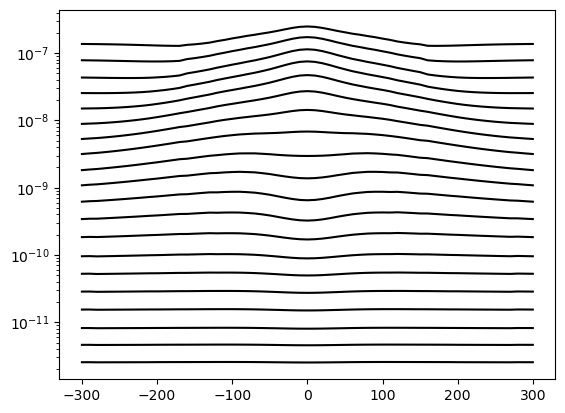

In [139]:
fig, ax = plt.subplots(1, 1)
line = 0

ax.semilogy(rx_x, dpred_values[:, line*len(rx_x): (line+1)*len(rx_x)].T, color="k");

In [140]:
relative_error = 0.05
noise_floor = 1e-13

In [141]:
data_invert = Data(survey, dobs = discretize.utils.mkvc(dpred_values))


In [142]:

source_list = data_invert.survey.source_list

with open("dobs.txt", "w") as f:
    f.write(f"IGNORE -9.9999000e+004\n")
    f.write(f"N_TRX {len(source_list)}\n\n")

    for src in source_list: 
        f.write(f"TRX_LOOP\n")
        f.write(f"{src.location[0]}\t{src.location[1]}\t{src.location[2]}\t{src.radius}\t0\t0\n\n")

        f.write(f"N_RECV 1\n")
        f.write(f"N_TIME {n_times_invert}\n")
        for i, t in enumerate(rx_times[:n_times_invert]):
            rx = src.receiver_list[0]
            datum = data_invert[src, rx][i]
            std = np.abs(datum) * relative_error + noise_floor
            f.write(
                f"{rx.locations[0, 0]}\t{rx.locations[0, 1]}\t{rx.locations[0, 2]}\t{t} "+
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # E data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t" + # H data 
                f"-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t-9.9999000e+004\t{datum}\t{std}\n"
            )
            
        f.write("\n")
            


        

# view inversion results

In [123]:
mrec = discretize.TreeMesh.read_model_UBC(ubc_mesh, "inv_003.con")

IndexError: index 83720 is out of bounds for axis 0 with size 61784

In [43]:
mrec

array([2.e-03, 2.e-03, 2.e-03, ..., 1.e-08, 1.e-08, 1.e-08])

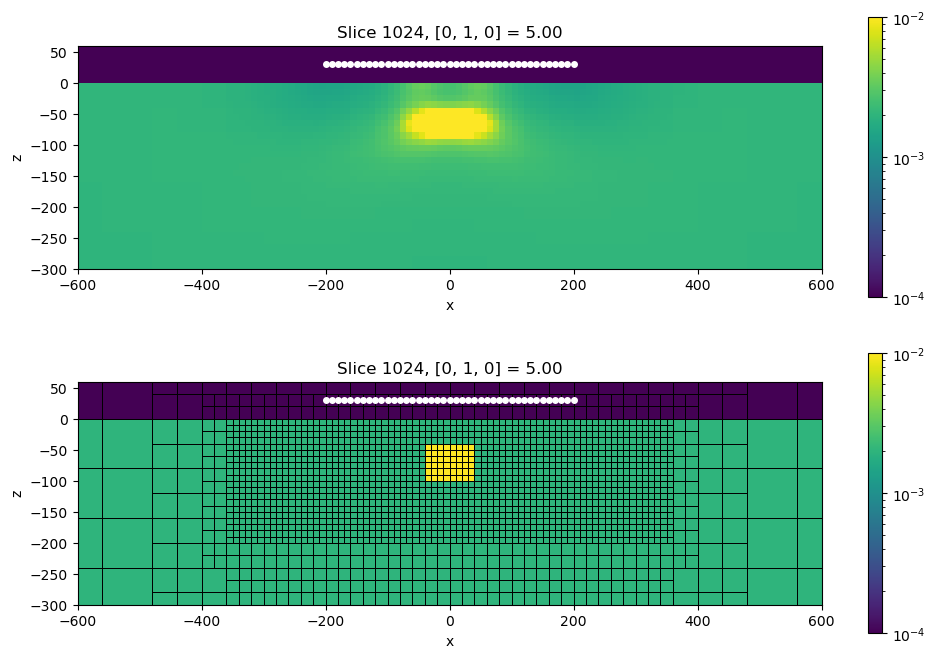

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plt.colorbar(
    ubc_mesh.plot_slice(
        mrec, ax=ax[0], pcolor_opts={"norm":LogNorm(vmin=1e-4, vmax=1e-2)}, 
        normal="y",
        # grid_opts={"color":"k","lw":0.5}
        # ind=1044
    )[0], ax=ax[0]
)

plt.colorbar(
    ubc_mesh.plot_slice(
        model, ax=ax[1], pcolor_opts={"norm":LogNorm(vmin=1e-4, vmax=1e-2)}, 
        normal="y",
        grid_opts={"color":"k","lw":0.5}
        # ind=1044
    )[0], ax=ax[1]
)

for a in ax.flatten(): 
    a.set_xlim(600*np.r_[-1, 1])
    a.set_ylim(np.r_[-300, 60])
    a.plot(rx_locs[:, 0], rx_locs[:, 2], "wo", ms=4)
    a.set_aspect(1)

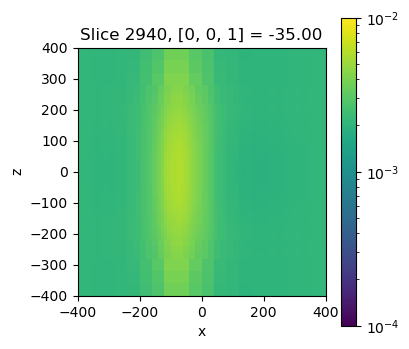

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

plt.colorbar(
    ubc_mesh.plot_slice(
        mrec, ax=ax, pcolor_opts={"norm":LogNorm(vmin=1e-4, vmax=1e-2)}, 
        normal="Z",
        # grid_opts={"color":"k","lw":0.5}
        ind=2940
    )[0], ax=ax
)
ax.set_xlim(np.r_[-1, 1]*400)
ax.set_ylim(np.r_[-1, 1]*400)
ax.set_aspect(1)